# Performing Basic Feature Engineering in Keras 

## Learning objectives


1. Create an input pipeline using tf.data.
2. Engineer features to create categorical, crossed, and numerical feature columns.


## Introduction 
In this lab, we utilize feature engineering to improve the prediction of housing prices using a Keras Sequential Model.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the [solution](../solutions/3_keras_basic_feat_eng.ipynb) for reference. 


Start by importing the necessary libraries for this lab.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
# Install Sklearn
!python3 -m pip install --user scikit-learn

### Restart the kernel

After you install the packages, you need to restart the notebook kernel so that it can find the packages. (Click **Kernel > Restart Kernel > Restart**).

In [1]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
#from keras.utils import plot_model

print("TensorFlow version: ",tf.version.VERSION)

2024-07-15 22:28:07.662383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 22:28:14.524900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-15 22:28:14.526405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

TensorFlow version:  2.11.0


Many of the Google Machine Learning Courses Programming Exercises use the  [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), which contains data drawn from the 1990 U.S. Census.  Our lab dataset has been pre-processed so that there are no missing values.

First, let's download the raw .csv data by copying the data from a cloud storage bucket.


In [2]:
if not os.path.isdir("../data"):
    os.makedirs("../data")

In [3]:
!gsutil cp gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv ../data    

Copying gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv...
/ [1 files][138.8 KiB/138.8 KiB]                                                
Operation completed over 1 objects/138.8 KiB.                                    


In [4]:
!ls -l ../data/

total 140
-rw-r--r-- 1 jupyter jupyter 142150 Jul 15 22:28 housing_pre-proc_toy.csv


Now, let's read in the dataset just copied from the cloud storage bucket and create a Pandas dataframe.

In [5]:
housing_df = pd.read_csv('../data/housing_pre-proc_toy.csv', on_bad_lines='skip')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


We can use .describe() to see some summary statistics for the numeric fields in our dataframe. Note, for example, the count row and corresponding columns. The count shows 2500.000000 for all feature columns. Thus, there are no missing values.

In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-121.501836,37.802288,30.088400,2522.734000,491.862400,1246.225200,458.122000,3.694312,170288.731200
std,1.015963,0.803090,13.878416,1988.411988,362.499497,925.075463,341.744308,1.859422,97550.278529
min,-124.300000,36.130000,2.000000,12.000000,4.000000,18.000000,2.000000,0.499900,22500.000000
25%,-122.200000,37.600000,18.000000,1420.750000,282.000000,718.000000,263.000000,2.357875,92950.000000
50%,-122.030000,37.800000,30.000000,2052.000000,402.000000,1030.500000,374.500000,3.262200,150800.000000
75%,-120.697500,37.960000,41.000000,3007.250000,581.250000,1488.250000,538.000000,4.662975,219650.000000
max,-118.910000,41.950000,52.000000,28258.000000,3864.000000,12203.000000,3701.000000,15.000100,500001.000000


####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [7]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1600 train examples
400 validation examples
500 test examples


Now, we need to output the split files.  We will specifically need the test.csv later for testing.  You should see the files appear in the home directory.


In [8]:
train.to_csv('../data/housing-train.csv', encoding='utf-8', index=False)

In [9]:
val.to_csv('../data/housing-val.csv', encoding='utf-8', index=False)

In [10]:
test.to_csv('../data/housing-test.csv', encoding='utf-8', index=False)

In [11]:
!head ../data/housing*.csv

==> ../data/housing-test.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-119.79,36.81,33,1461,261,494,254,4.25,132200,INLAND
-122.18,37.78,50,1642,322,713,284,3.2984,160700,NEAR BAY
-121.97,37.97,27,1691,289,807,296,6.1168,210500,INLAND
-122.23,37.8,52,1192,289,772,257,2.3833,146900,NEAR BAY
-119.45,36.6,42,510,88,247,99,2.5,73000,INLAND
-120.79,38.24,19,1003,235,538,190,2.9821,90400,INLAND
-119.71,36.8,17,1415,267,861,293,3.25,81400,INLAND
-119.91,36.83,29,2205,366,1072,345,3.8056,165400,INLAND
-120.79,38.43,40,1391,246,546,214,3.9107,129800,INLAND

==> ../data/housing-train.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-121.93,37.78,2,227,35,114,49,3.1591,434700,<1H OCEAN
-121.97,37.97,24,1330,183,656,205,5.0092,244100,INLAND
-121.79,38.01,17,4032,814,1749,618,3.1728,146800,INLAND
-121.84,39.

## Lab Task 1: Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. 

Here, we create an input pipeline using tf.data.  This function is missing two lines.  Correct and run the cell.

In [12]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
# TODO 1a
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Next we initialize the training and validation datasets.

In [13]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

2024-07-15 22:29:26.307696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-15 22:29:26.308890: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-15 22:29:26.308958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240715-162053): /proc/driver/nvidia/version does not exist
2024-07-15 22:29:26.313409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [14]:
# TODO 1b
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['households'])
    print('A batch of ocean_proximity:', feature_batch['ocean_proximity'])
    print('A batch of targets:', label_batch)

Every feature: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
A batch of households: tf.Tensor(
[184 542 275 722 276 654 862 398 694 372 504 551 351 313 377 377 542 720
 363 279 244 465 397 615 335 160  58 208 573 207 402 317], shape=(32,), dtype=int64)
A batch of ocean_proximity: tf.Tensor(
[b'NEAR BAY' b'INLAND' b'NEAR BAY' b'INLAND' b'NEAR BAY' b'INLAND'
 b'INLAND' b'NEAR BAY' b'NEAR BAY' b'INLAND' b'NEAR BAY' b'NEAR BAY'
 b'INLAND' b'INLAND' b'<1H OCEAN' b'NEAR BAY' b'INLAND' b'NEAR BAY'
 b'INLAND' b'NEAR BAY' b'NEAR BAY' b'INLAND' b'INLAND' b'INLAND'
 b'NEAR BAY' b'NEAR BAY' b'NEAR BAY' b'INLAND' b'NEAR BAY' b'INLAND'
 b'<1H OCEAN' b'NEAR BAY'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor(
[179900 100000 162900 110600 206300  96500  73000 170500 210200 181800
 370900 120700 141300 184800 269800 246200 126500  97500 141200 157800
 184900 151400  53600 122600 346800 189600 

We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

#### Numeric columns
The output of a feature column becomes the input to the model. A numeric is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In the California housing prices dataset, most columns from the dataframe are numeric.  Let' create a variable called **numeric_cols** to hold only the numerical feature columns.

In [15]:
# Let's create a variable called `numeric_cols` to hold only the numerical feature columns.
# TODO 1c
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

#### Scaler function
It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling. Here we are creating a function named 'get_scal' which takes a list of numerical features and returns a 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

Next, we scale the numerical feature columns that we assigned to the variable "numeric cols".

In [16]:
# 'get_scal' function takes a list of numerical features and returns a 'minmax' function
# 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number.
# Scalar def get_scal(feature):
# TODO 1d
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [17]:
# TODO 1e
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

Next, we should validate the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [18]:
print('Total number of feature coLumns: ', len(feature_columns))

Total number of feature coLumns:  8


### Using the Keras Sequential Model

Next, we will run this cell to compile and fit the Keras Sequential model.

In [19]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
50/50 [==============================] - 2s 7ms/step - loss: 36908228608.0000 - mse: 36908228608.0000 - val_loss: 38036443136.0000 - val_mse: 38036443136.0000
Epoch 2/32
50/50 [==============================] - 0s 2ms/step - loss: 36101754880.0000 - mse: 36101754880.0000 - val_loss: 37080137728.0000 - val_mse: 37080137728.0000
Epoch 3/32
50/50 [==============================] - 0s 2ms/step - loss: 34989371392.0000 - mse: 34989371392.0000 - val_loss: 35706056704.0000 - val_mse: 35706056704.0000
Epoch 4/32
50/50 [==============================] - 0s 2ms/step - loss: 33299195904.0000 - mse: 33299195904.0000 - val_loss: 33532581888.0000 - val_mse: 33532581888.0000
Epoch 5/32
50/50 [==============================] - 0s 2ms/step - loss: 30811740160.0000 - mse: 30811740160.0000 - val_loss: 30627788800.0000 - val_mse: 30627788800.0000
Epoch 6/32
50/50 [==============================] - 0s 2ms/step - loss: 27782955008.0000 - mse: 27782955008.0000 - val_loss: 27245334528.0000 - val_ms

Next we show loss as  Mean Square Error (MSE).  Remember that MSE is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable (e.g. housing median age) and predicted values.

In [20]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

50/50 [==============================] - 0s 2ms/step - loss: 14637897728.0000 - mse: 14637897728.0000
Mean Squared Error 14637897728.0


#### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

In [21]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  

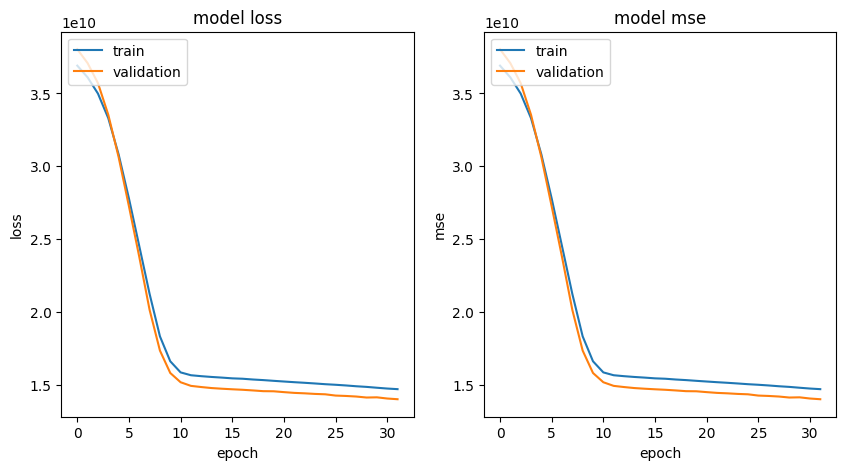

In [22]:
plot_curves(history, ['loss', 'mse'])

### Load test data

Next, we read in the test.csv file and validate that there are no null values.  

Again, we can use .describe() to see some summary statistics for the numeric fields in our dataframe.  The count shows 500.000000 for all feature columns. Thus, there are no missing values.

In [23]:
test_data = pd.read_csv('../data/housing-test.csv')
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,-121.566340,37.818500,30.416000,2669.082000,512.63000,1296.208000,476.728000,3.806117,177469.408000
std,0.935804,0.691101,13.867934,2501.274104,422.68337,1116.233134,397.984242,1.842774,94170.285172
min,-122.410000,36.160000,4.000000,60.000000,15.00000,36.000000,15.000000,0.536000,39600.000000
25%,-122.200000,37.640000,18.000000,1418.750000,277.75000,717.250000,259.000000,2.413625,96925.000000
50%,-122.030000,37.800000,30.000000,2071.000000,404.50000,1024.000000,379.500000,3.480450,160400.000000
75%,-120.987500,37.962500,42.000000,3087.250000,610.00000,1557.500000,568.500000,4.833025,228050.000000
max,-118.910000,39.820000,52.000000,28258.000000,3864.00000,12203.000000,3701.000000,12.591500,500001.000000


Now that we have created an input pipeline using tf.data and compiled a Keras Sequential Model, we now create the input function for the test data and to initialize the test_predict variable.

In [24]:
# TODO 1f
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [25]:
test_predict = test_input_fn(dict(test_data))

#### Prediction:  Linear Regression

Before we begin to feature engineer our feature columns, we should predict the median house value.  By predicting the median house value now, we can then compare it with the median house value after feature engineering.

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the housing features you want to predict the median_house_value for. Note:  We are predicting the model locally.

In [26]:
predicted_median_house_value = model.predict(test_predict)

2/2 [==============================] - 0s 4ms/step


Next, we run two predictions in separate cells - one where ocean_proximity=INLAND and one where ocean_proximity= NEAR OCEAN. 

In [27]:
# Ocean_proximity is INLAND
model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]),
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
}, steps=1)

1/1 [==============================] - 0s 164ms/step


array([[358692.44]], dtype=float32)

In [28]:
# Ocean_proximity is NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

1/1 [==============================] - 0s 29ms/step


array([[201631.7]], dtype=float32)

The arrays returns a predicted value.  What do these numbers mean?  Let's compare this value to the test set.  

Go to the test.csv you read in a few cells up.  Locate the first line and find the median_house_value - which should be 249,000 dollars near the ocean. What value did your model predicted for the median_house_value? Was it a solid model performance? Let's see if we can improve this a bit with feature engineering!  


## Lab Task 2: Engineer features to create categorical and numerical features

Now we create a cell that indicates which features will be used in the model.  
Note:  Be sure to bucketize 'housing_median_age' and ensure that 'ocean_proximity' is one-hot encoded.  And, don't forget your numeric values!

In [29]:
# TODO 2a
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

bucketized_cols = ['housing_median_age']

# indicator columns,Categorical features
categorical_cols = ['ocean_proximity']

Next, we scale the numerical, bucktized, and categorical feature columns that we assigned to the variables in the preceding cell.

In [30]:
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [31]:
# All numerical features - scaling
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

### Categorical Feature
In this dataset, 'ocean_proximity' is represented as a string.  We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

Next, we create a categorical feature using 'ocean_proximity'.

In [32]:
# TODO 2b
for feature_name in categorical_cols:
    vocabulary = housing_df[feature_name].unique()
    categorical_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = fc.indicator_column(categorical_c)
    feature_columns.append(one_hot)

### Bucketized Feature

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a homes' age. Instead of representing the house age as a numeric column, we could split the home age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

Next we create a bucketized column using 'housing_median_age'


In [33]:
# TODO 2c
age = fc.numeric_column("housing_median_age")

# Bucketized cols
age_buckets = fc.bucketized_column(age, boundaries=[10, 20, 30, 40, 50, 60, 80, 100])
feature_columns.append(age_buckets)

### Feature Cross

Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features.

Next, we create a feature cross of 'housing_median_age' and 'ocean_proximity'.

In [34]:
# TODO 2d
vocabulary = housing_df['ocean_proximity'].unique()
ocean_proximity = fc.categorical_column_with_vocabulary_list('ocean_proximity',
                                                             vocabulary)

crossed_feature = fc.crossed_column([age_buckets, ocean_proximity],
                                    hash_bucket_size=1000)
crossed_feature = fc.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Next, we should validate the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [35]:
print('Total number of feature columns: ', len(feature_columns))

Total number of feature columns:  11


Next, we will run this cell to compile and fit the Keras Sequential model.  This is the same model we ran earlier.

In [36]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns,
                                              dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
50/50 [==============================] - 1s 9ms/step - loss: 37593542656.0000 - mse: 37593542656.0000 - val_loss: 38942404608.0000 - val_mse: 38942404608.0000
Epoch 2/32
50/50 [==============================] - 0s 3ms/step - loss: 37137260544.0000 - mse: 37137260544.0000 - val_loss: 38200516608.0000 - val_mse: 38200516608.0000
Epoch 3/32
50/50 [==============================] - 0s 3ms/step - loss: 35940782080.0000 - mse: 35940782080.0000 - val_loss: 36453392384.0000 - val_mse: 36453392384.0000
Epoch 4/32
50/50 [==============================] - 0s 3ms/step - loss: 33715175424.0000 - mse: 33715175424.0000 - val_loss: 33643814912.0000 - val_mse: 33643814912.0000
Epoch 5/32
50/50 [==============================] - 0s 3ms/step - loss: 30511874048.0000 - mse: 30511874048.0000 - val_loss: 29836976128.0000 - val_mse: 29836976128.0000
Epoch 6/32
50/50 [==============================] - 0s 3ms/step - loss: 26564448256.0000 - mse: 26564448256.0000 - val_loss: 25489203200.0000 - val_ms

Next, we show loss and mean squared error then plot the model.

In [37]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

50/50 [==============================] - 0s 2ms/step - loss: 14465414144.0000 - mse: 14465414144.0000
Mean Squared Error 14465414144.0


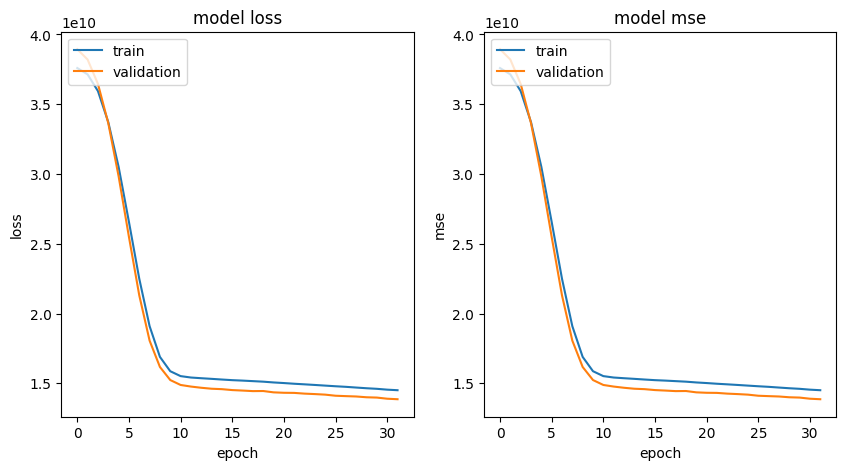

In [38]:
plot_curves(history, ['loss', 'mse'])

Next we create a prediction model.  Note:  You may use the same values from the previous prediciton.  

In [39]:
# TODO 2e
# Median_house_value is $249,000, prediction is $234,000 NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

1/1 [==============================] - 0s 227ms/step


array([[201259.02]], dtype=float32)

### Analysis 

The array returns a predicted value.  Compare this value to the test set you ran earlier. Your predicted value may be a bit better.

Now that you have your "feature engineering template" setup, you can experiment by creating additional features.  For example, you can create derived features, such as households per population, and see how they impact the model.  You can also experiment with replacing the features you used to create the feature cross.
 

Copyright 2022 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.